<font size = 5> Feature Selection Methods in Logistic Regression <font> 

In [13]:
library(dplyr)
library(ggplot2)
library(MASS)

In [2]:
df <- read.csv("stroke_data.csv")
head(df)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1


**Checking out numerical columns**

In [3]:
numerical_cols <- df %>% 
                    dplyr::select(age, avg_glucose_level, bmi) %>%
                    names()

numerical_cols

[1] "age"               "avg_glucose_level" "bmi"

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."


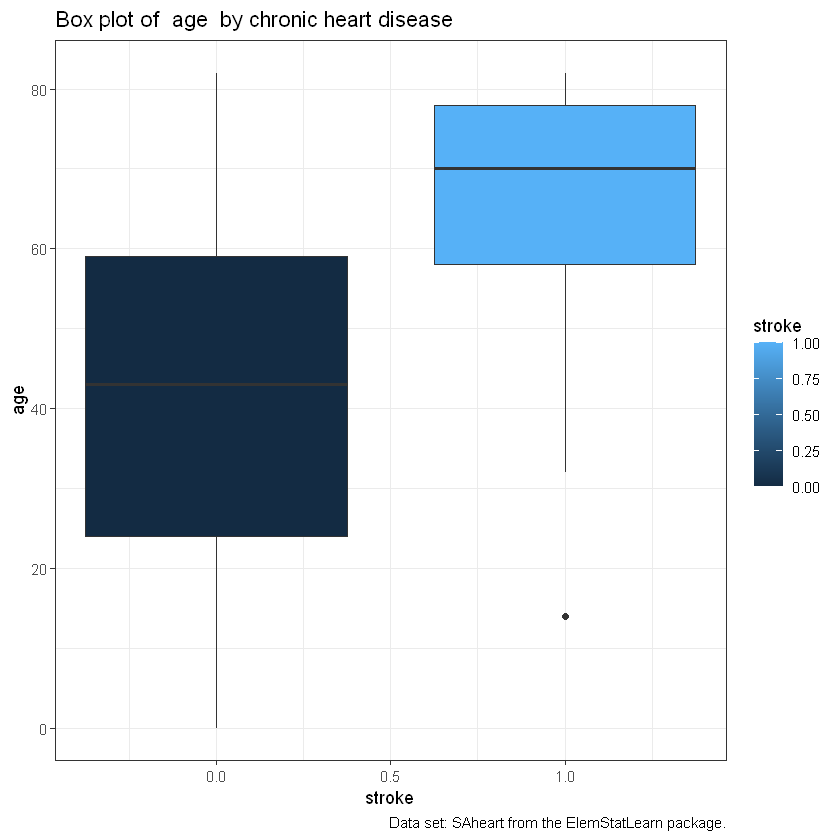

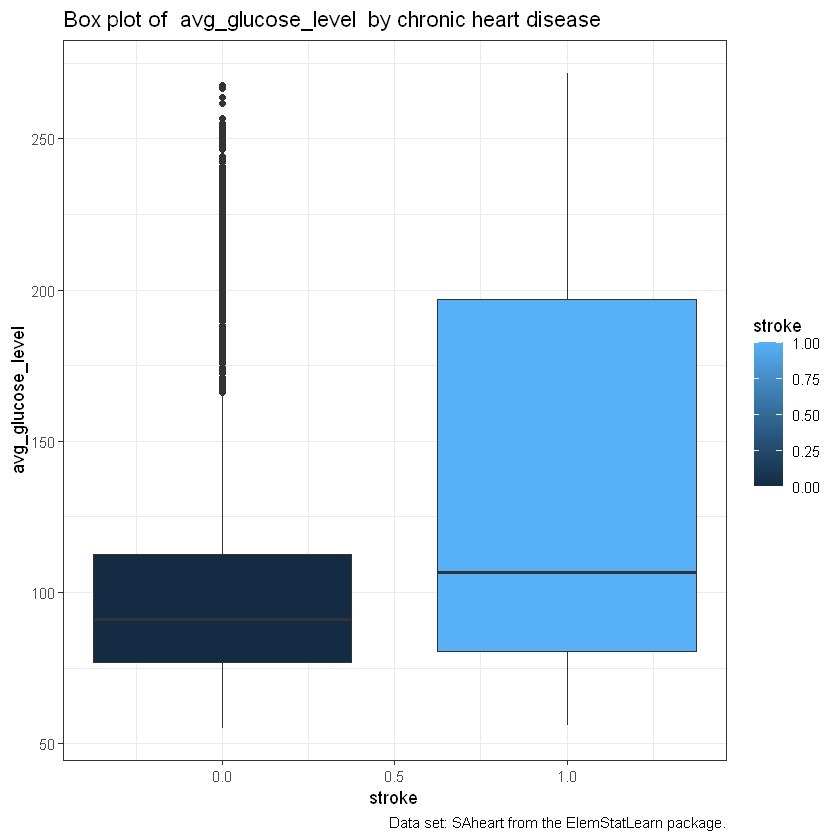

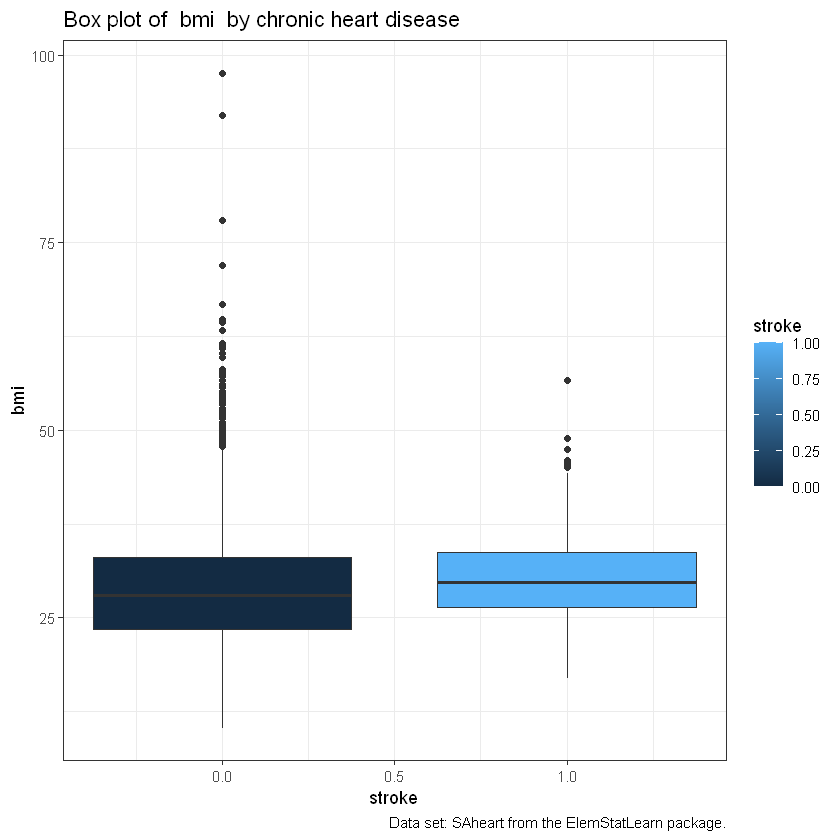

In [4]:
for(j in numerical_cols) plot(df[,c("stroke",j)] %>%
  ggplot() +
  aes_string(y = j) + 
  aes(x = stroke, fill = stroke,group = stroke) + 
  geom_boxplot() + 
  theme_bw() + 
  labs(
    title = paste(
      "Box plot of ",j," by chronic heart disease"
    ),
    caption = "Data set: SAheart from the ElemStatLearn package."
  ))

Looking at the box plots of the numerical values against the target value, age has different distributions for two categories of the target. <br>
avg_glucose_level is worth keeping as well.
Id is not an informative predictor and we can remove it.

**Checking out Categorical columns**

`summarise()` has grouped output by 'hypertension'. You can override using the `.groups` argument.


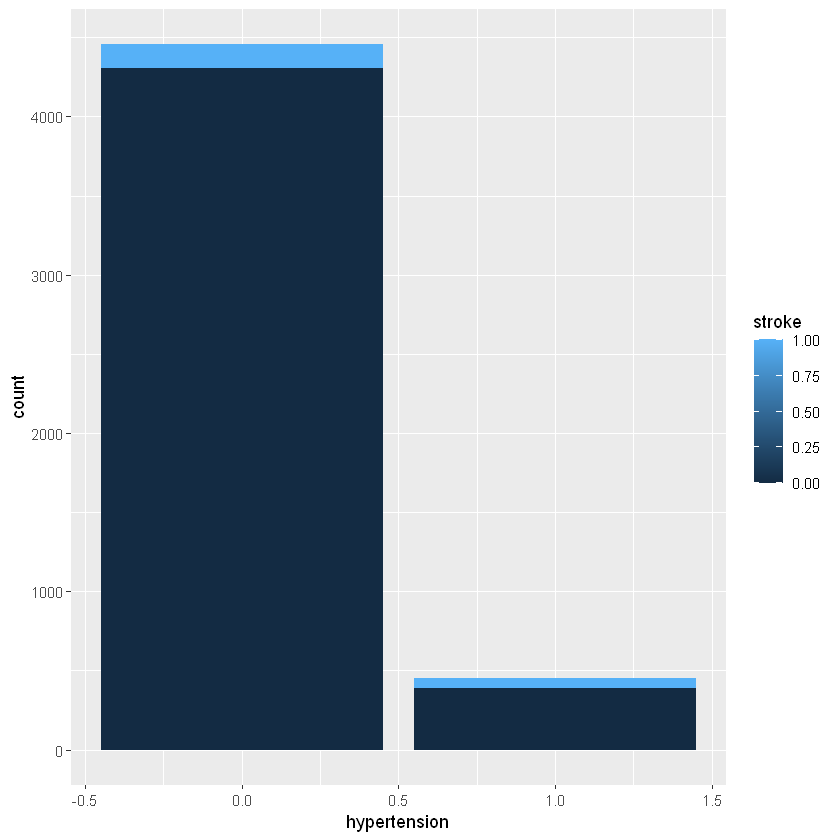

In [5]:
df %>%
    group_by(hypertension,stroke) %>%
    summarise(count = dplyr::n()) %>%
    ungroup() %>%
    group_by(hypertension) %>%
    mutate(percent = count* 100 / sum(count),
          label = paste0(count, "\n", round(percent), "%")
           )%>%
ggplot() +
aes(x = hypertension, y = count, fill = stroke, label = label) +
geom_col() 

`summarise()` has grouped output by 'Residence_type'. You can override using the `.groups` argument.


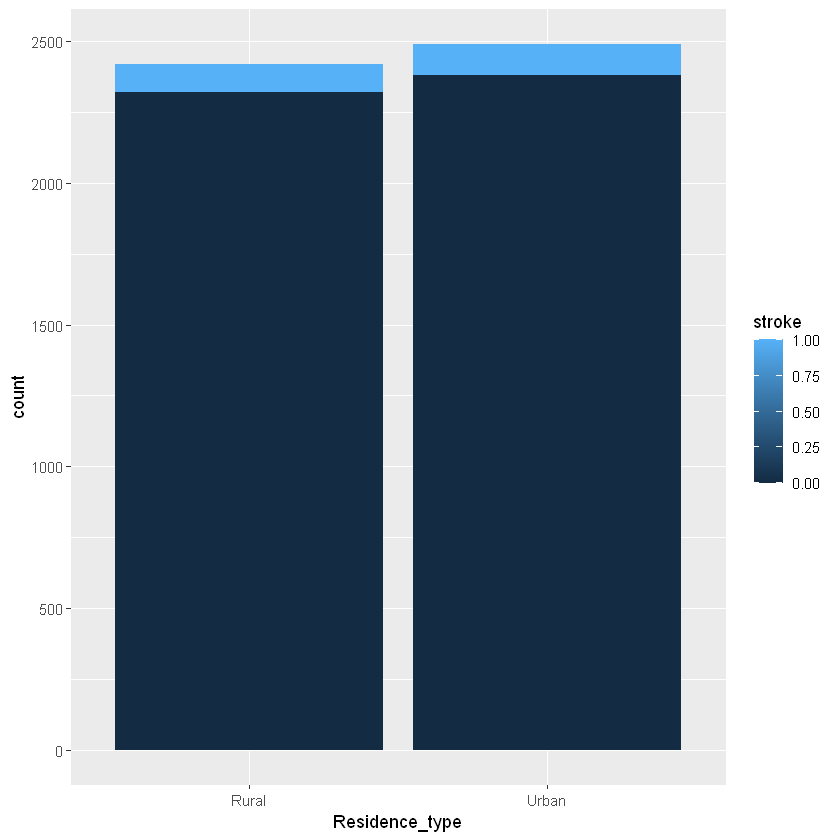

In [6]:
df %>%
    group_by(Residence_type,stroke) %>%
    summarise(count = dplyr::n()) %>%
    ungroup() %>%
    group_by(Residence_type) %>%
    mutate(percent = count* 100 / sum(count),
          label = paste0(count, "\n", round(percent), "%")
           )%>%
ggplot() +
aes(x = Residence_type, y = count, fill = stroke, label = label) +
geom_col() 

`summarise()` has grouped output by 'ever_married'. You can override using the `.groups` argument.


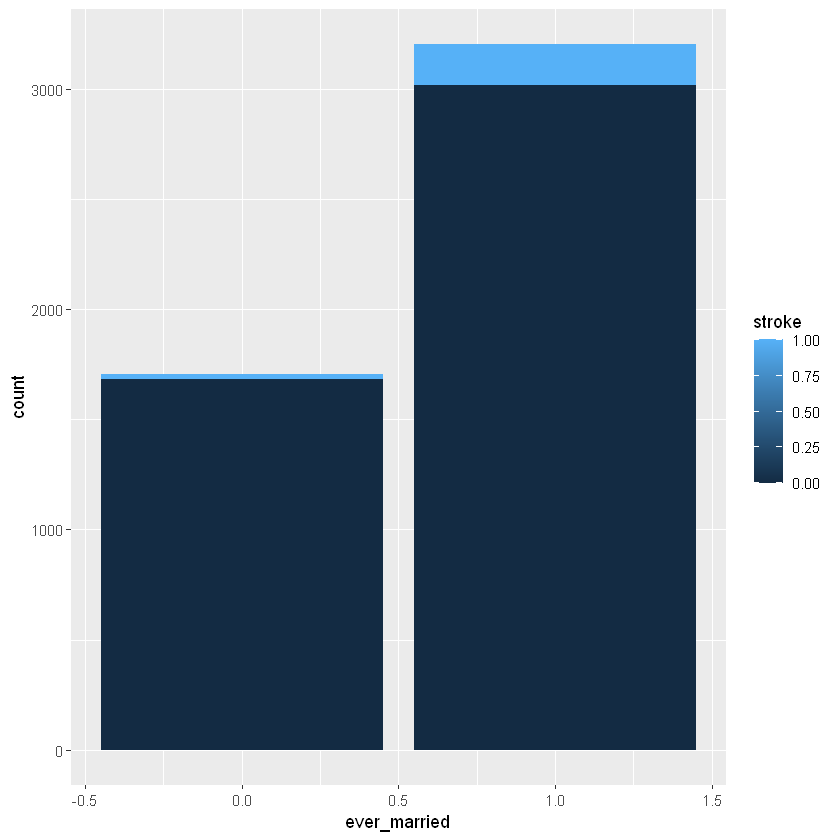

In [7]:
df %>%
    mutate(ever_married = ifelse(ever_married == "Yes", 1, 0)) %>%
    group_by(ever_married,stroke) %>%
    summarise(count = dplyr::n()) %>%
    ungroup() %>%
    group_by(ever_married) %>%
    mutate(percent = count* 100 / sum(count),
          label = paste0(count, "\n", round(percent), "%")
           )%>%
ggplot() +
aes(x = ever_married, y = count, fill = stroke, label = label) +
geom_col() 

ever_married and hypertension are also proper columns to include in our model.

In [8]:
#create model with selected features
fs_model <- glm(formula = stroke ~ age + avg_glucose_level + ever_married + hypertension,
                                data = df,
                                family = binomial()
                                )
fs_model


Call:  glm(formula = stroke ~ age + avg_glucose_level + ever_married + 
    hypertension, family = binomial(), data = df)

Coefficients:
      (Intercept)                age  avg_glucose_level    ever_marriedYes  
        -7.697703           0.069958           0.005074          -0.110130  
     hypertension  
         0.546451  

Degrees of Freedom: 4908 Total (i.e. Null);  4904 Residual
Null Deviance:	    1728 
Residual Deviance: 1378 	AIC: 1388

*Train a forward selection model with all possible predictors being considered in the model.*

In [9]:
#create full model
full_model <- glm(
                formula = stroke ~ . -id,
                data = df,
                family = binomial()
                )   
summary(full_model)


Call:
glm(formula = stroke ~ . - id, family = binomial(), data = df)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -7.360e+00  1.067e+00  -6.895 5.37e-12 ***
genderMale                 -1.463e-02  1.544e-01  -0.095 0.924525    
genderOther                -1.135e+01  2.400e+03  -0.005 0.996225    
age                         7.348e-02  6.347e-03  11.578  < 2e-16 ***
hypertension                5.249e-01  1.750e-01   2.999 0.002711 ** 
heart_disease               3.488e-01  2.072e-01   1.683 0.092381 .  
ever_marriedYes            -1.152e-01  2.473e-01  -0.466 0.641394    
work_typeGovt_job          -6.817e-01  1.114e+00  -0.612 0.540660    
work_typeNever_worked      -1.082e+01  5.090e+02  -0.021 0.983036    
work_typePrivate           -5.208e-01  1.100e+00  -0.473 0.635943    
work_typeSelf-employed     -9.459e-01  1.119e+00  -0.845 0.397906    
Residence_typeUrban         4.514e-03  1.500e-01   0.030 0.975990    
avg_g

In [10]:
#model with forward elimination
forward_model <-   full_model %>%
                            MASS::stepAIC(
                            direction = "forward",
                            k = log(nrow(df)),
                            trace = 0
                            )
forward_model


Call:  glm(formula = stroke ~ (id + gender + age + hypertension + heart_disease + 
    ever_married + work_type + Residence_type + avg_glucose_level + 
    bmi + smoking_status) - id, family = binomial(), data = df)

Coefficients:
               (Intercept)                  genderMale  
                 -7.359650                   -0.014625  
               genderOther                         age  
                -11.353772                    0.073481  
              hypertension               heart_disease  
                  0.524857                    0.348763  
           ever_marriedYes           work_typeGovt_job  
                 -0.115175                   -0.681655  
     work_typeNever_worked            work_typePrivate  
                -10.823495                   -0.520849  
    work_typeSelf-employed         Residence_typeUrban  
                 -0.945890                    0.004514  
         avg_glucose_level                         bmi  
                  0.004652 

In [11]:
#model with backward elimination
backward_model <-   full_model %>%
                            MASS::stepAIC(
                            direction = "backward",
                            k = log(nrow(df)),
                            trace = 0
                            )
backward_model


Call:  glm(formula = stroke ~ age + hypertension + avg_glucose_level, 
    family = binomial(), data = df)

Coefficients:
      (Intercept)                age       hypertension  avg_glucose_level  
        -7.766874           0.069571           0.547026           0.005047  

Degrees of Freedom: 4908 Total (i.e. Null);  4905 Residual
Null Deviance:	    1728 
Residual Deviance: 1378 	AIC: 1386

In [12]:
data.frame(
    model = c("fs_model", "forward_model", "full_model", "backward_model"),
    AIC = c(round(AIC(fs_model)), round(AIC(forward_model)), round(AIC(full_model)), round(AIC(backward_model)))
          ) %>% 
    arrange(AIC)


model,AIC
<chr>,<dbl>
backward_model,1386
fs_model,1388
forward_model,1397
full_model,1397


We see that the lowest AIC is from the backward selection model, and after that the model from our feature selection. forward selection and full model both have the highest AIC which indicates that forward selection was not usefull for our model.